In [1]:
import turtle
import numpy as np
import os
import time
import math
from math import pi
import subprocess
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
def __deprecated_drawLineSegments(segments, img_w=300, img_h=300, draw_size=250):
    minX = (img_w - draw_size)/2
    minY = abs((img_h - draw_size)/2)
    minX = 10
    minY = 10
    
    span = np.max(segments) - np.min(segments)
    ratio = draw_size/span
    shift = -np.min(segments)
    
    shiftX = -float('inf')
    shiftY = -float('inf')
    for segment in segments:
        shiftX = max(shiftX, -float(segment[0][0]), -float(segment[1][0]))
        shiftY = max(shiftY, -float(segment[0][1]), -float(segment[1][1]))
    
    qx = lambda v : (v + shiftX) * ratio + minX
    qy = lambda v : (v + shiftY) * ratio + minY
    
    img = Image.new('RGB', (img_w, img_h), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    for segment in segments:
        draw.line((qx(segment[0][0]), qy(segment[0][1]), qx(segment[1][0]), qy(segment[1][1])), fill=256)
        
    return img

In [3]:
def draw_point(draw, p, r=2.5):
    box = [p[0]-r, p[1]-r, p[0]+r, p[1]+r]
    draw.ellipse(xy=box, fill='red', outline='red')

In [4]:
def draw_line_segments(segments, img_w=300, img_h=300, margin=50):
    minX = 10
    minY = 10

    all_x_c = [x[0][0] for x in segments]
    all_x_c.extend([x[1][0] for x in segments])
    all_x_c = np.array(all_x_c)
    
    all_y_c = [x[0][1] for x in segments]
    all_y_c.extend([x[1][1] for x in segments])
    all_y_c = np.array(all_y_c)
    
    span = np.max(segments) - np.min(segments)
    ratio = (max(img_w, img_h)-margin)/span
    shiftX = -np.min(all_x_c)
    shiftY = -np.min(all_y_c)
    
    qx = lambda v : (v + shiftX) * ratio + minX
    qy = lambda v : (v + shiftY) * ratio + minY
    
    img = Image.new('RGB', (img_w, img_h), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    for segment in segments:
        draw.line((qx(segment[0][0]), qy(segment[0][1]), qx(segment[1][0]), qy(segment[1][1])), fill=256)
    for segment in segments:
        draw_point(draw, [qx(segment[0][0]), qy(segment[0][1])])
        draw_point(draw, [qx(segment[1][0]), qy(segment[1][1])])
        
    return img

In [5]:
#TODO and reflect: Maybe these lines info shouldn't be hardcoded
def getSegmentsFromFile(file_path):
    file = open(file_path, 'r')
    lines = file.readlines()
    
    n = int(lines[0])
    print('N =', n)
    print(lines[1] + lines[2] + lines[3])
    
    parseLine = lambda ln : [[float(ln.split()[0]), float(ln.split()[1])],\
                             [float(ln.split()[2]), float(ln.split()[3])]]
    segments = [parseLine(ln) for ln in lines[4:]]
    
    return segments

In [6]:
def get_and_draw_from_file(file_name, img_w=300, img_h=300):
    # subprocess.check_call(['./printout_path_greedy_test', '<', file_name, '>', 'temp_file.out'])
    #output = subprocess.check_output(['./printout_path_greedy_test', '<', file_name]).decode('utf-8')
    os.system('./printout_path_greedy_test < ' + file_name + ' > temp_file.out')
    time.sleep(0.5)  # Super hacky please fix this
    ret = draw_line_segments(getSegmentsFromFile('temp_file.out'), img_w, img_h)
    subprocess.check_call(['rm', 'temp_file.out'])
    return ret

N = 11
Planarity: PLANAR
Max degree: 4
Stretch: 3.45837



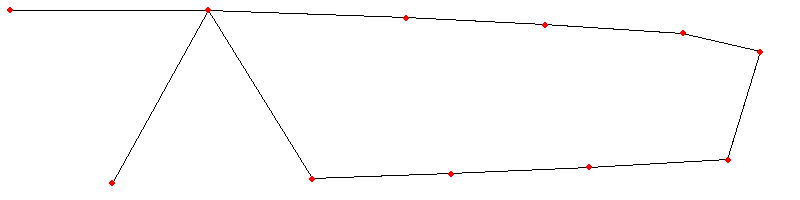

In [7]:
get_and_draw_from_file('../pointsets/hand/013.txt', img_w=800, img_h=200)

N = 11
Planarity: PLANAR
Max degree: 4
Stretch: 3.45837



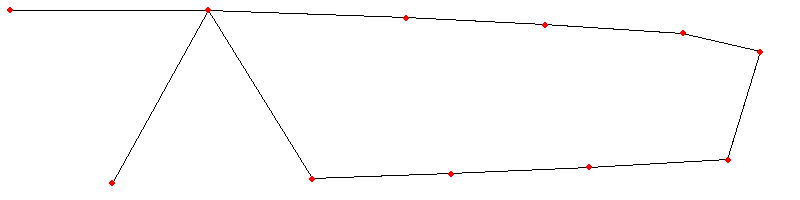

In [8]:
get_and_draw_from_file('../pointsets/hand/example_deg4.txt', img_w=800, img_h=200)

N = 11
Planarity: PLANAR
Max degree: 4
Stretch: 3.4582



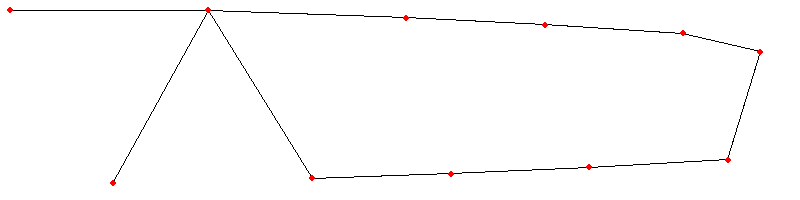

In [9]:
get_and_draw_from_file('../pointsets/hand/example_deg4_rounded.txt', img_w=800, img_h=200)

N = 11
Planarity: PLANAR
Max degree: 4
Stretch: 3.4582



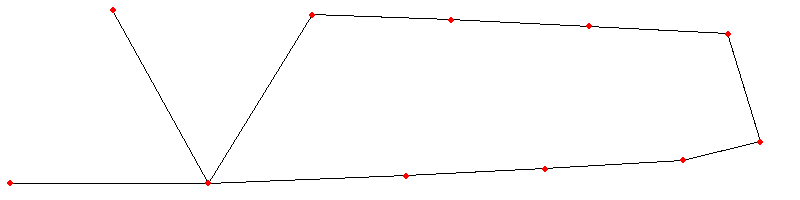

In [11]:
get_and_draw_from_file('../pointsets/hand/example_deg4_rounded_flipped.txt', img_w=800, img_h=200)

N = 6
Planarity: PLANAR
Max degree: 3
Stretch: 1.75807



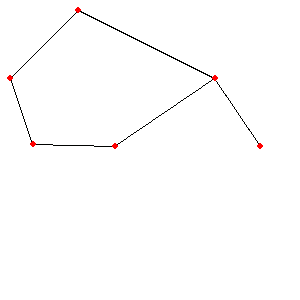

In [114]:
get_and_draw_from_file('../pointsets/hand/new_002.txt')

### Lots of helper functions for counter-example creation

In [12]:
# Rotate point P around pivot A by angle theta
def point_rotation(P, A, theta):
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    
    NP = A - P
    NP = np.array([NP[0] * cos_t - NP[1] * sin_t, NP[0] * sin_t + NP[1] * cos_t])
    NP = NP + P
    return NP

# distance between two points
def point_dist(A, B):
    return np.sqrt(np.sum((B-A)**2))

def get_next_A(a, v, angle=0.01, scale=0.7):
    vprime = 2*a - v
    diff = (vprime-a)
    lendiff = np.sqrt(np.sum(diff**2))
    if (lendiff > scale):
        diff /= lendiff
        diff *= scale
        vprime = a + diff
    return point_rotation(a, vprime, angle)

def angle_between(A, P, B):
    ap = np.sqrt(np.sum((A-P)**2))
    pb = np.sqrt(np.sum((B-P)**2))
    return math.acos(np.dot((A-P), (B-P))/(ap*pb))

# reflect around the Y axis
def refY(P):
    return P * [-1, 1]

def check_collinearity(points):
    for a in range(len(points)):
        for b in range(len(points)):
            for c in range(len(points)):
                if (a == b or b == c or a == c):
                    continue
                if (abs(angle_between(points[a], points[b], points[c])-pi)<0.000001):
                    return True
    return False

def are_convex(points):
    return len(points) == len(ConvexHull(points).vertices)

In [13]:
def path_length(points):
    p = 0.
    for i in range(1, len(points)):
        p += point_dist(points[i-1], points[i])
    return p

In [14]:
def max_length_in_path(points):
    p = 0.
    for i in range(1, len(points)):
        p = max(p, point_dist(points[i-1], points[i]))
    return p

In [15]:
def print_points(all_points):
    print(len(all_points))
    for p in all_points:
        print(p[0], p[1])

In [16]:
def min_all_pairs(all_points):
    return min([
        point_dist(all_points[i], all_points[j])
        for i in range(len(all_points))
        for j in range(i+1, len(all_points))
    ])

# VERY IMPORTANT

In [108]:
"""
paper_points = [
    [-48.25, 87.58],
    [-100.0, 0.0],
    [278.61, 20.99],
    [262.35, 75.61],
    [239.70, 11.69],
    [192.46, 79.46],
    [169.83, 7.49],
    [122.53, 82.61],
    [99.92, 3.99],
    [52.58, 85.06],
    [0, 0]
]
paper_points = [np.array(x) for x in paper_points]
"""

#paper_x = np.array([-48.25,-100.0,278.61,262.35,239.70,192.46,169.83,122.53,99.92,52.58,0.0])/10.
#paper_y = -np.array([87.58, 0.0, 20.99, 75.61, 11.69, 79.46, 7.49, 82.61, 3.99, 85.06, 0.0])/10.
paper_x = np.array([-3, 1.61, 6, -2, 8, 0])
paper_y = np.array([0, 3, 0, 2.9, 3, -3])
#paper_points = np.zeros((11, 2))
paper_points = np.zeros((len(paper_x), 2))
paper_points[:,0] = paper_x
paper_points[:,1] = paper_y

In [109]:
print(point_dist(paper_points[10], paper_points[9]))
print(point_dist(paper_points[10], paper_points[8]))
print(point_dist(paper_points[10], paper_points[0]))
print(point_dist(paper_points[10], paper_points[1]))

IndexError: index 10 is out of bounds for axis 0 with size 6

In [110]:
are_convex(paper_points)

True

In [111]:
check_collinearity(paper_points)

False

In [112]:
N = len(paper_points)
for i in range(N):
    print(angle_between(paper_points[i], paper_points[(i+1)%N], paper_points[(i+2)%N]))

1.9652055317049535
0.25171137690190065
0.3577666545436805
0.6335014421066193
1.7126933813990606
1.362306920523372


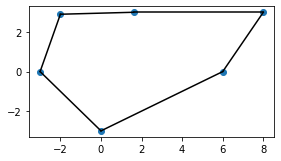

In [113]:
import matplotlib.pyplot as plt
hull = ConvexHull(paper_points)
points = paper_points
plt.figure(figsize=(0.4*(np.max(paper_x)-np.min(paper_x)), 0.4*(np.max(paper_y)-np.min(paper_y))))

plt.plot(points[:, 0], points[:, 1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.show()

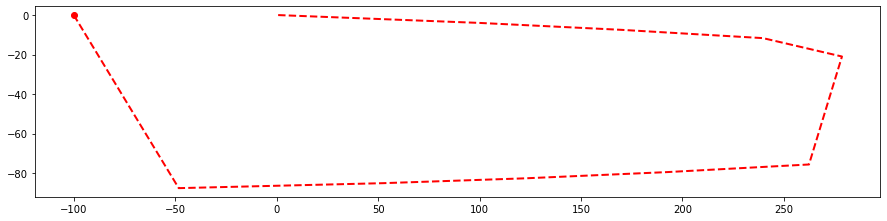

In [60]:
plt.figure(figsize=(0.04*(np.max(paper_x)-np.min(paper_x)), 0.04*(np.max(paper_y)-np.min(paper_y))))
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

### Counter-example construction for degree 5

update: Ended up proving none exist

In [13]:
eps = 0.001
V = np.array([0., 0.])
A = get_next_A(V, np.array([-100., 0.]), angle=eps/2, scale=10000.)
B = .00010*point_rotation(V, A, pi/6 - eps)  
C = np.array([0., B[1]+0.000001])
D = refY(B)
E = refY(A)

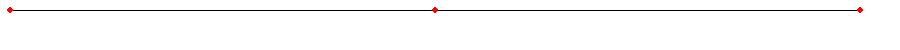

In [14]:
draw_line_segments([[V, A], [A, B], [B, V], [V, C], [C, D], [D, E], [V, E]], img_w=900, img_h=50)

In [15]:
A, B, C, D

(array([9.99999875e+01, 4.99999979e-02]),
 array([0.00866275, 0.00499567]),
 array([0.        , 0.00499667]),
 array([-0.00866275,  0.00499567]))

In [16]:
are_convex([V, C, A, B, D, E])

False

In [17]:
point_dist(V, A), point_dist(A, B), point_dist(B, V)

(100.0, 99.99133487487114, 0.01)

In [18]:
print('max allowed difference', point_dist(B, V)*3/(5*math.pi+3))
print('actual difference', point_dist(V, A) - point_dist(A, B))

max allowed difference 0.0016035951947477299
actual difference 0.008665125128857198


In [19]:
angle_between(V, A, B), angle_between(B, V, A), angle_between(A, B, V)

(4.9917695673335436e-05, 0.5225987755982987, 2.618943960293569)

In [20]:
math.pi/6-angle_between(B,V,A), 5*math.pi/6-angle_between(A, B, V)

(0.001000000000000112, -0.0009500823020744953)

In [21]:
#beg_r=0.00001
#end_r=0.1
#for _ in range(5000):
#    mid = (beg_r+end_r)/2.
#    B = mid*point_rotation(V, A, pi/6 - eps) 
#    if (5*math.pi/6-angle_between(A, B, V) < .8*eps):
#        beg_r = mid
#    elif (5*math.pi/6-angle_between(A, B, V) > 1.2*eps):
#        end_r = mid
#beg_r, end_r

In [22]:
max_p = (3+4*math.pi)/3.*point_dist(A, B)
min_p = (3+4*math.pi)/3.*point_dist(A, V) - point_dist(V, B)
print('min_p =', min_p)
print('max_p =', max_p)

min_p = 518.8690204786391
max_p = 518.8340589622472


In [23]:
angle_between(V, A, B)

4.9917695673335436e-05

In [24]:
check_collinearity([V, A, B, C, D, E])

False

In [25]:
point_dist(A, B)

99.99133487487114

In [26]:
# Generating A-path
A1 = get_next_A(A, V, scale=30.)
A2 = get_next_A(A1, A, scale=30.)
A3 = get_next_A(A2, A1, scale=30.)
A4 = get_next_A(A3, A2, scale=30.)
A5 = get_next_A(A4, A3, scale=30.)
A6 = get_next_A(A5, A4, scale=30.)
A7 = get_next_A(A6, A5, scale=30.)

In [27]:
# Generating B-path
B1 = get_next_A(B, C, angle=-eps, scale=30.)
B2 = get_next_A(B1, B, angle=-eps, scale=30.)
B3 = get_next_A(B2, B1, angle=-eps, scale=30.)
B4 = get_next_A(B3, B2, angle=-eps, scale=30.)
B5 = get_next_A(B4, B3, angle=-eps, scale=30.)
B6 = get_next_A(B5, B4, angle=-eps, scale=30.)
B7 = get_next_A(B6, B5, angle=-eps, scale=30.)

In [28]:
path_length([A, A1, A2, A3, A4, A5, A6, A7, B7, B6, B5, B4, B3, B2, B1, B])

519.8950482107996

In [29]:
max_length_in_path([A, A1, A2, A3, A4, A5, A6, A7, B7, B6, B5, B4, B3, B2, B1, B])

309.83440893970914

In [30]:
point_dist(A, B)

99.99133487487114

In [31]:
min_all_pairs([A, A1, A2, A3, A4, A5, A6, A7, B7, B6, B5, B4, B3, B2, B1, B])

0.008662753012926856

In [32]:
# reflecting A-path to get E-path
E1 = refY(A1)
E2 = refY(A2)
E3 = refY(A3)
E4 = refY(A4)
E5 = refY(A5)
E6 = refY(A6)
E7 = refY(A7)

In [33]:
# reflecting B-path to get D-path
D1 = refY(B1)
D2 = refY(B2)
D3 = refY(B3)
D4 = refY(B4)
D5 = refY(B5)
D6 = refY(B6)
D7 = refY(B7)

In [34]:
path_length([D, D1, D2, D3, D4, D5, D6, D7, E7, E6, E5, E4, E3, E2, E1, E])

519.8950482107997

In [35]:
max_length_in_path([D, D1, D2, D3, D4, D5, D6, D7, E7, E6, E5, E4, E3, E2, E1, E])

309.83440893970914

Interesting points


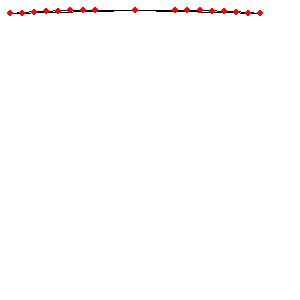

In [36]:
print('Interesting points')
draw_line_segments([
    [V, A], [A, B], [B, V], [B, C], [V, C],
    [C, D], [D, E], [E, V], [V, D],
    [A, A1], [A1, A2], [A2, A3], [A3, A4], [A4, A5], [A5, A6], [A6, A7],
    [B, B1], [B1, B2], [B2, B3], [B3, B4], [B4, B5], [B5, B6], [B6, B7],
    [A7, B7],
    [E, E1], [E1, E2], [E2, E3], [E3, E4], [E4, E5], [E5, E6], [E6, E7],
    [D, D1], [D1, D2], [D2, D3], [D3, D4], [D4, D5], [D5, D6], [D6, D7],
    [D7, E7]
])

In [37]:
print_points([A, A1, A2, A3, A4, A5, A6, A7,
              B7, B6, B5, B4, B3, B2, B1, B, C,
              D, D1, D2, D3, D4, D5, D6, D7,
              E7, E6, E5, E4, E3, E2, E1, E, V])

34
99.99998750000026 0.04999999791666669
129.99833376519402 0.3649942098235735
159.9920302359535 0.9799511351036907
189.9780775676263 1.8948092785769528
219.9534771804675 3.1094771551913913
249.91523155949528 4.623833299171565
279.86034455423976 6.437726276165035
309.78582167835566 8.550974698385675
0.06930138925077949 0.004746113367346439
0.0606388555320946 0.004807752118313501
0.051976264505935524 0.00486072830618626
0.04331362483489255 0.004905041877988534
0.03465094518160464 0.004940692789406754
0.02598823420875071 0.004967681004790013
0.017325500579041024 0.004986006497150096
0.008662752955208488 0.0049956692481615125
0.0 0.004996669248161513
-0.008662752955208488 0.0049956692481615125
-0.017325500579041024 0.004986006497150096
-0.02598823420875071 0.004967681004790013
-0.03465094518160464 0.004940692789406754
-0.04331362483489255 0.004905041877988534
-0.051976264505935524 0.00486072830618626
-0.0606388555320946 0.004807752118313501
-0.06930138925077949 0.004746113367346439
-309.7

N = 34
Planarity: PLANAR
Max degree: 3
Stretch: 4.97996



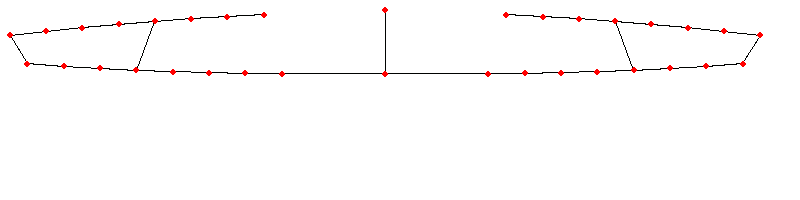

In [38]:
get_and_draw_from_file('../pointsets/hand/018.txt', img_w=800, img_h=200)

In [39]:
point_dist(A2, B2)

159.96901320705751

#### Looking for the right angles

In [40]:
# beta >= alpha > 0
# pi > alpha + beta >= 3pi/4
# t * sin(alpha+beta) + sin(alpha) >= t * sin(beta)
t = (3+4*pi)/3
epsilon = 0.0001
step=0.05

for alpha in np.arange(step, pi, step):
    for beta in np.arange(max(3*pi/4-alpha, alpha), pi-alpha-step, step):
        if t*np.sin(alpha+beta) + np.sin(alpha) >= t*np.sin(beta) - epsilon:
            print('alpha:', alpha, 'beta:', beta)

print('no examples found')

no examples found


In [41]:
beg_t = 1.
end_t = (3+4*pi)/3
epsilon = 0.0001
step = 0.1

for _ in range(50):
    t = (beg_t+end_t)/2
    
    found = False
    for alpha in np.arange(step, pi, step):
        if found:
            break
        for beta in np.arange(max(3*pi/4-alpha, alpha), pi-alpha-step, step):
            if t*np.sin(alpha+beta) + np.sin(alpha) >= t * np.sin(beta) - epsilon:
                found = True
                break
    
    if found:
        beg_t = t
    else:
        end_t = t

print('beg_t = {}'.format(beg_t))

beg_t = 3.6557025219286245


In [42]:
# similar as above but with different inequality
# sin(alpha+beta) + sin(alpha) >= sin(beta)
t = (3+4*pi)/3
epsilon = 0.01
step=0.01

for alpha in np.arange(step, pi, step):
    for beta in np.arange(max(3*pi/4-alpha, alpha), pi-alpha-step, step):
        if np.sin(alpha+beta) + np.sin(alpha) >= np.sin(beta) - epsilon:
            pass
            #print('alpha:', alpha, 'beta:', beta, 'sin a:', np.sin(alpha),
            #     'sin a+b:', np.sin(alpha+beta), 'sin b:', np.sin(beta))

print('no examples found')

no examples found


In [43]:
print(t)

5.1887902047863905


### Counter-example construction for degree 4
This section is just full of little things for me to find a counter-example

In [44]:
# Original version
V = np.array([0., 0.])
C = np.array([-0.5, np.sqrt(3)/2])
D = np.array([-1., 0.])
B = np.array([0.5, np.sqrt(3)/2])
#A = np.array([0.999, 0.04471017781])
#A = np.array([1., 0.])

In [45]:
# Scaled version
V = np.array([0., 0.])
C = np.array([-50., 100*np.sqrt(3)/2])
D = np.array([-100., 0.])
B = np.array([50., 100*np.sqrt(3)/2])

In [46]:
# This is important if I want to not depend on the sort for distances
# It's easier to define the points in "nice" locations and then rotate
C = point_rotation(V, C, -0.01)
B = point_rotation(V, B, -0.015)

In [47]:
# Original version
A = get_next_A(V, D, angle=0.04, scale=1.0)
A1 = get_next_A(A, V)
A2 = get_next_A(A1, A)
A3 = get_next_A(A2, A1, angle=pi/18, scale=0.4)

In [48]:
# Scaled version
A = get_next_A(V, D, angle=0.04, scale=100.0)
A1 = get_next_A(A, V, scale=70.)
A2 = get_next_A(A1, A, scale=70.)
A3 = get_next_A(A2, A1, angle=pi/18, scale=40.)

In [49]:
# Original version
T = -0.01
B1 = get_next_A(B, C, angle=T, scale=0.7)
B2 = get_next_A(B1, B, angle=T, scale=0.8)
B3 = get_next_A(B2, B1, angle=T, scale=0.9)

In [50]:
# Scaled version
T = -0.01
B1 = get_next_A(B, C, angle=T, scale=70.)
B2 = get_next_A(B1, B, angle=T, scale=80.)
B3 = get_next_A(B2, B1, angle=T, scale=90.)

N = 11
Planarity: PLANAR
Max degree: 4
Stretch: 3.45837



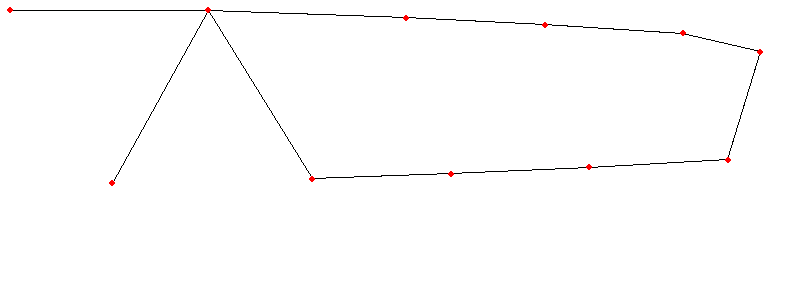

In [51]:
get_and_draw_from_file('../pointsets/hand/013.txt', img_w=800)

Convex hull


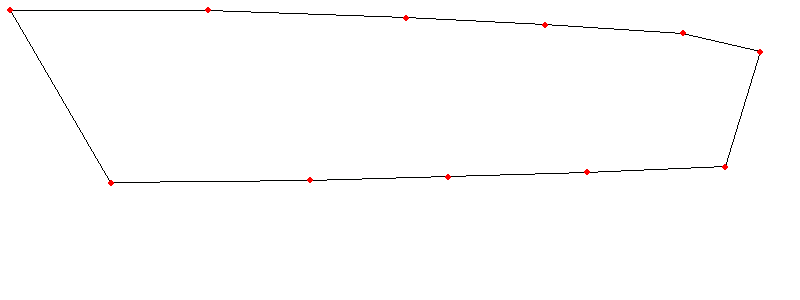

In [52]:
print('Convex hull')
draw_line_segments([
    [B3, A3],
    [B3, B2], [B2, B1], [B1, B],
    [A3, A2], [A2, A1], [A1, A],
    [A, V], [B, C],
    [C, D], [V, D]], img_w=800)

In [53]:
# printing all points
#all_points = [V, C, D, A, A1, A2, A3, B, B1, B2, B3]
all_points = [C, D, A3, B3, A2, B2, A1, B1, A, B, V]
print(len(all_points))
for p in all_points:
    print(p[0], p[1])

11
-49.131489050733386 87.09820195421754
-100.0 0.0
278.6114863027456 20.99050464871304
261.1754717643324 79.01925477899111
239.70656668920972 11.694955721172022
191.2386809991664 81.99335926091308
169.83252889374543 7.497475267610899
121.27564649526082 84.26795878727201
99.9200106660978 3.998933418663416
51.29336449776368 85.84282590001075
0.0 0.0


In [54]:
are_convex(all_points)

True

In [55]:
print('Are there three collinear points?')
check_collinearity(all_points)

Are there three collinear points?


False

In [56]:
def cross(A, B, C):
    return ((A-B)[0]*(C-B)[1] - (A-B)[1]*(C-B)[0])

In [57]:
def verify_hull(points, eps=0.001):
    N = len(points)
    for i in range(N):
        if (cross(points[i], points[(i+1)%N], points[(i+2)%N]) < eps):
            return False
    return True

In [58]:
cross(C, B, B1)

70.30171811672781

In [59]:
verify_hull([V, D, C, B, B1, B2, B3, A3, A2, A1, A])

True

In [60]:
# yet another sanity check
ang_sum = 0.0
ppp = [V, D, C, B, B1, B2, B3, A3, A2, A1, A]
for i in range(len(ppp)):
    ang_sum += angle_between(ppp[i], ppp[(i+1)%11], ppp[(i+2)%11])

print('angle (V, D, C)    =', angle_between(V, D, C))
print('angle (D, C, B)    =', angle_between(D, C, B))
print('angle (C, B, B1)   =', angle_between(C, B, B1))
print('angle (B, B1, B2)  =', angle_between(B, B1, B2))
print('angle (B1, B2, B3) =', angle_between(B1, B2, B3))
print('angle (B2, B3, A3) =', angle_between(B2, B3, A3))
print('angle (B3, A3, A2) =', angle_between(B3, A3, A2))
print('angle (A3, A2, A1) =', angle_between(A3, A2, A1))
print('angle (A2, A1, A)  =', angle_between(A2, A1, A))
print('angle (A1, A, V)   =', angle_between(A1, A, V))
print('angle (A, V, D)    =', angle_between(A, V, D))

print('actual angle sum   = ', ang_sum)
print('expected angle sum = ', (len(all_points)-2)*pi)

angle (V, D, C)    = 1.0421975511965977
angle (D, C, B)    = 2.086895102393196
angle (C, B, B1)   = 3.131592653589803
angle (B, B1, B2)  = 3.131592653589803
angle (B1, B2, B3) = 3.131592653589803
angle (B2, B3, A3) = 1.9051860914041263
angle (B3, A3, A2) = 1.5134394873850998
angle (A3, A2, A1) = 2.96705972839036
angle (A2, A1, A)  = 3.131592653589803
angle (A1, A, V)   = 3.131592653589803
angle (A, V, D)    = 3.1015926535897926
actual angle sum   =  28.274333882308188
expected angle sum =  28.274333882308138


In [61]:
point_dist(A2, B2)

85.38736138035526

In [62]:
point_dist(A3, B3)

60.59166976297982

In [63]:
point_dist(B3, B2)

70.0

In [64]:
point_dist(A, A1)

70.0

### Attempt at non-planar graph
This is the part where I try to build a graph that is not planar

In [65]:
### Finding an alpha
step = 0.01
epsilon = 0.0001
t = (3+4*pi)/3

for alpha in np.arange(step, pi/2, step):
    for gamma in np.arange(pi/2, pi-alpha, step):
        # condition1
        lhs = 1. + 2*np.sin(gamma-pi/2)*np.sin(alpha+gamma)/np.sin(alpha)
        rhs = np.sin(gamma)/np.sin(alpha)
        condition1 = lhs >= rhs-epsilon
        
        # condition2 -- regarding path
        lhs = t * np.sin(alpha+gamma)/np.sin(alpha) + 1
        rhs = t * np.sin(gamma)/np.sin(alpha)
        condition2 = lhs >= rhs-epsilon
        
        # condition3 -- regarding path + 2pi/3
    
        if condition1 and condition2:
            print('alpha:', alpha, 'gamma:', gamma)

In [89]:
step = 0.05
epsilon = 0.00001
K = 2*pi/3.
t = (3+4*pi)/3

c1_min_gamma = 2*pi
c2_max_gamma = 0
c1_min_diff = _
for beta in np.arange(0.00001, pi/2, step):
    for gamma in np.arange(pi/2, pi-beta, step):
        # condition 1
        lhs = np.sin(beta) + 2*np.sin(beta+gamma)*np.cos(pi-gamma)
        rhs = np.sin(gamma)
        condition1 = lhs >= rhs-epsilon
        
        # condition 2
        lhs = t * np.sin(beta+gamma) + K * np.sin(beta)
        rhs = t * np.sin(gamma)
        condition2 = lhs > rhs
        
        #if condition1 and condition2:
        #    print('beta:', beta, 'gamma:', gamma)
        if condition2:
            c2_max_gamma = max(c2_max_gamma, gamma)
            print('condition2; beta: {}, gamma: {}'.format(beta, gamma))
        
        if condition1:
            c1_min_gamma = min(c1_min_gamma, gamma)
            print('condition1; beta: {}, gamma: {}'.format(beta, gamma))
            
        if condition1 and condition2:
            print('BOTH!')
            
print('c1_min_gamma = {}\nc2_max_gamma = {}'.format(c1_min_gamma, c2_max_gamma))
print('done, step=', step)

condition2; beta: 1e-05, gamma: 1.5707963267948966
condition2; beta: 1e-05, gamma: 1.6207963267948966
condition2; beta: 1e-05, gamma: 1.6707963267948966
condition2; beta: 1e-05, gamma: 1.7207963267948967
condition2; beta: 1e-05, gamma: 1.7707963267948967
condition2; beta: 1e-05, gamma: 1.8207963267948968
condition2; beta: 1e-05, gamma: 1.8707963267948968
condition2; beta: 1e-05, gamma: 1.9207963267948969
condition2; beta: 1e-05, gamma: 1.970796326794897
condition1; beta: 1e-05, gamma: 2.1207963267948973
condition1; beta: 1e-05, gamma: 2.170796326794897
condition1; beta: 1e-05, gamma: 2.220796326794897
condition1; beta: 1e-05, gamma: 2.270796326794897
condition1; beta: 1e-05, gamma: 2.3207963267948974
condition1; beta: 1e-05, gamma: 2.3707963267948973
condition1; beta: 1e-05, gamma: 2.420796326794897
condition1; beta: 1e-05, gamma: 2.4707963267948974
condition1; beta: 1e-05, gamma: 2.5207963267948976
condition1; beta: 1e-05, gamma: 2.5707963267948974
condition1; beta: 1e-05, gamma: 2.62

In [79]:
step = 0.001
epsilon = 0.00001

K = (2*pi)/3
#K = (3+4*pi)/3.
beg_t = 1.
end_t = 2*(3+4*pi)/3.
for _ in range(30):
    found = False
    t = (beg_t+end_t)/2.
    
    for beta in np.arange(step, pi/2, step):
        if found:
            break
        for gamma in np.arange(pi/2, pi-beta, step):
            # condition 1
            lhs = np.sin(beta) + 2*np.sin(beta+gamma)*np.cos(pi-gamma)
        rhs = np.sin(gamma)
        condition1 = lhs >= rhs-epsilon
        
        # condition 2
        lhs = t * np.sin(beta+gamma) + K * np.sin(beta)
        rhs = t * np.sin(gamma)
        condition2 = lhs > rhs
        
        #if condition1 and condition2:
        #    found = True
        #    break
        if condition2:
            found = True
            break

    if found:
        beg_t = t
    else:
        end_t = t
        
print('beg_t = {}\nend_t = {}'.format(beg_t, end_t))
print('difference from K = {}'.format(K-beg_t))

beg_t = 2.0960635860398167
end_t = 2.096063594773369
difference from K = -0.0016684836466214215


In [68]:
A = np.array([100., 0])
B = np.array([50., 100*np.sqrt(3)/2])
C = refY(B)
D = refY(A)

In [69]:
# Scaled version
A1 = get_next_A(A, np.array([0.0, 0.0]), scale=70.)
A2 = get_next_A(A1, A, scale=70.)
A3 = get_next_A(A2, A1, angle=pi/18, scale=50.)

In [70]:
# Scaled version
T = -0.01
B1 = get_next_A(B, C, angle=T, scale=70.)
B2 = get_next_A(B1, B, angle=T, scale=80.)
B3 = get_next_A(B2, B1, angle=T, scale=90.)

In [71]:
# Reflect points
C1 = refY(B1)
C2 = refY(B2)
C3 = refY(B3)
D1 = refY(A1)
D2 = refY(A2)
D3 = refY(A3)

Interesting parts


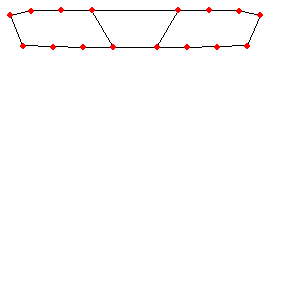

In [72]:
print('Interesting parts')
draw_line_segments([
    [A, A1], [A1, A2], [A2, A3],
    [B, B1], [B1, B2], [B2, B3], [B3, A3],
    [C, C1], [C1, C2], [C2, C3], [C3, D3],
    [D, D1], [D1, D2], [D2, D3],
    [A, B],
    [C, D],
    [B, C],
    [D, A]])

In [73]:
verify_hull([D, D1, D2, D3, C3, C2, C1, C, B, B1, B2, B3, A3, A2, A1, A])

True

In [74]:
# important path sum
point_dist(B, B1) +\
point_dist(B1, B2) +\
point_dist(B2, B3) +\
point_dist(B3, A3) +\
point_dist(A3, A2) +\
point_dist(A2, A1) +\
point_dist(A, A1)

476.39249164490377

In [75]:
# printing all points
all_points = [A, D1, D2, D3, C3, C2, C1, C, B, B1, B2, B3, A3, A2, A1, A]
print(len(all_points))
for p in all_points:
    print(p[0], p[1])

16
100.0 0.0
-169.99650002916655 0.6999883333916666
-239.98250049582697 2.099895001924982
-289.0394037958189 11.765309561851858
-259.9510028582562 82.40296036234417
-189.98250049582703 84.50264537651887
-119.99650002916657 85.90255204505219
-50.0 86.60254037844386
50.0 86.60254037844386
119.99650002916657 85.90255204505219
189.98250049582703 84.50264537651887
259.9510028582562 82.40296036234417
289.0394037958189 11.765309561851858
239.98250049582697 2.099895001924982
169.99650002916655 0.6999883333916666
100.0 0.0


N = 16
Planarity: PLANAR
Max degree: 2
Stretch: 4.76392



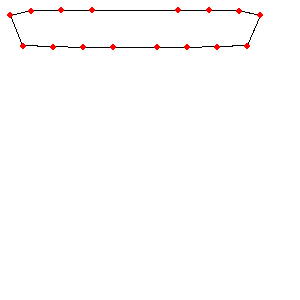

In [76]:
get_and_draw_from_file('../pointsets/hand/016.txt')

In [77]:
# ->mark kyle<- and goodwin
# spanning ratio of a delauney triangulation
# inequalities - littlewood, polya, hardy

# degree < pi/4 is a local property

In [78]:
# Feb 20 - WADS
# mid January - EuroCG